In [1]:
import renn
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

from jax.experimental import stax, optimizers

import numpy as np

from renn.losses import multiclass_xent

from tqdm import tqdm
from functools import partial
from renn import serialize

from data_processing import analysis_utils as au

In [3]:
from src import data

In [84]:
dataset_config = {'dataset': 'dbpedia',
                  'max_pad': 400,
                  'batch_size': 256,
                  'num_classes': 14}

In [85]:
vocab_size, train_dset, test_dset = data.get_dataset(dataset_config)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13}


In [86]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

In [87]:
emb_size = 32

input_shape = (-1, dataset_config['max_pad'])
l2_pen = 0

# Linear model
init_fun, apply_fun = stax.serial(
    renn.embedding(vocab_size, emb_size),
    SequenceSum(),
    stax.Dense(dataset_config['num_classes']),
    )

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

# Hack to set the embedding to 0 for 0
emb = initial_params[0]
new_emb = np.array(emb)
new_emb[0] = np.zeros(emb_size)
initial_params = [jnp.array(new_emb), *initial_params[1:]]

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    data_loss = multiclass_xent(logits, batch['labels'])
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

f_df = jax.value_and_grad(xent)

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    return jnp.mean(predictions == batch['labels'])



In [88]:
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []

@jax.jit
def step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params):
    return jnp.array([accuracy(params, batch) for batch in tfds.as_numpy(test_dset)])

In [89]:
for epoch in range(3):
    print('=====================================')
    print(f'== Epoch #{epoch}')
    p = get_params(state)
    acc = np.mean(test_acc(p))
    print(f'== Test accuracy: {100. * acc:0.2f}%')
    print('=====================================')
    
    for batch in tfds.as_numpy(train_dset):
        k = len(losses)
        state, loss = step(k, state, batch)
        losses.append(loss)

        if k % 100 == 0:
            p = get_params(state)
            print(f'[step {k}]\tLoss: {np.mean(losses[k-100:k]):0.4f}', flush=True)
            
print('=====================================')
print(f'== Epoch #{epoch}')
p = get_params(state)
acc = np.mean(test_acc(p))
print(f'== Test accuracy: {100. * acc:0.2f}%')
print('=====================================')

== Epoch #0
== Test accuracy: 6.98%
[step 0]	Loss: nan


/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[step 100]	Loss: 0.5293
[step 200]	Loss: 0.1718
[step 300]	Loss: 0.1396
[step 400]	Loss: 0.1201
[step 500]	Loss: 0.1019
[step 600]	Loss: 0.1113
[step 700]	Loss: 0.0894
[step 800]	Loss: 0.0965
[step 900]	Loss: 0.0886
[step 1000]	Loss: 0.0806
[step 1100]	Loss: 0.1030
[step 1200]	Loss: 0.0828
[step 1300]	Loss: 0.0802
[step 1400]	Loss: 0.0776
[step 1500]	Loss: 0.0787
[step 1600]	Loss: 0.0820
[step 1700]	Loss: 0.0712
[step 1800]	Loss: 0.0743
[step 1900]	Loss: 0.0754
[step 2000]	Loss: 0.0821
[step 2100]	Loss: 0.0789
== Epoch #1
== Test accuracy: 97.93%
[step 2200]	Loss: 0.0699
[step 2300]	Loss: 0.0337
[step 2400]	Loss: 0.0330
[step 2500]	Loss: 0.0305
[step 2600]	Loss: 0.0275
[step 2700]	Loss: 0.0255
[step 2800]	Loss: 0.0258
[step 2900]	Loss: 0.0278
[step 3000]	Loss: 0.0237
[step 3100]	Loss: 0.0266
[step 3200]	Loss: 0.0229
[step 3300]	Loss: 0.0297
[step 3400]	Loss: 0.0280
[step 3500]	Loss: 0.0284
[step 3600]	Loss: 0.0282
[step 3700]	Loss: 0.0272
[step 3800]	Loss: 0.0303
[step 3900]	Loss: 0.03

### Dimensionality of the logits

In [90]:
num_words = 5000

In [91]:
most_common_words = np.arange(num_words).reshape(1,-1).T
output_logits = {'initial': apply_fun(initial_params, most_common_words),
                 'final': apply_fun(p, most_common_words)}

In [92]:
f = lambda x: x[1:] - x[0]
logit_changes = {k: f(v) for k,v in output_logits.items()}

In [93]:
PCA_obj = {k: au.PCA_rnn() for k in output_logits.keys()}

for k in output_logits.keys():
    PCA_obj[k].fit(logit_changes[k])

In [94]:
dimensionalities = {k: au.cumulative_var_explained(PCA_obj[k]) for k in PCA_obj.keys()}

(-1.0, 15.0)

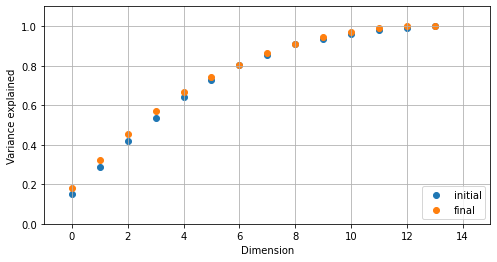

In [95]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1,dataset_config['num_classes']+1)

In [21]:
dimensionalities

{'initial': array([0.2802981, 0.527935 , 0.7413199, 0.8776858, 0.9999999],
       dtype=float32),
 'final': array([0.7871699 , 0.93477964, 0.982127  , 0.99823457, 1.        ],
       dtype=float32)}